In [1]:
# Optimization of Random Forest Classifier: cross validation, feature selection, hyperparameter optimization 
# and final prediction

In [78]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import scikitplot as skplt

In [3]:
# training data

train_features = pd.read_csv('X_train_pumps.csv', index_col=0)
train_labels = pd.read_csv('y_train_pumps.csv', index_col=0)

train_features.shape, train_labels.shape

((59400, 39), (59400, 1))

In [4]:
# test data

test_features = pd.read_csv('X_test_pumps.csv', index_col=0)

test_features.shape

(14850, 39)

In [5]:
# data wrangling/feature engineering

In [6]:
def wrangle_data(df):
    # drop columns that do not appear to provide no obvious information or are repetitive 
    df = df.drop(['funder', 'installer','date_recorded', 'wpt_name', 'num_private', 'subvillage','region_code',
                  'lga', 'ward', 'public_meeting', 'recorded_by','scheme_management', 'scheme_name', 
                  'permit','extraction_type', 'extraction_type_group', 'management', 'management_group',
                  'payment', 'water_quality', 'quantity', 'source', 'source_class', 
                  'waterpoint_type_group','construction_year'], axis=1)
    
    # dummies for categorical columns
    dummy_list = ['basin', 'region','district_code','extraction_type_class','payment_type','quality_group',
                  'quantity_group','source_type','waterpoint_type']
    for each in dummy_list:
        try:
            df = pd.get_dummies(data=df, prefix=dummy_list, columns=dummy_list, drop_first=True)
        except:
            Exception
            continue
            
    # longtitide: replacing 0 with mean 
    df['longitude'].replace(0.000000, 34.213823, inplace=True)
    
    # MinMax Scaling of numerical columns
    scale = MinMaxScaler()
    
    amount_tsh_scaled = scale.fit_transform(df[['amount_tsh']])
    df['amount_tsh_scaled'] = amount_tsh_scaled
    df = df.drop(['amount_tsh'], axis=1)
    
    gps_height_scaled = scale.fit_transform(df[['gps_height']])
    df['gps_height_scaled'] = gps_height_scaled
    df = df.drop(['gps_height'], axis=1)
    
    longitude_scaled = scale.fit_transform(df[['longitude']])
    df['longitude_scaled'] = longitude_scaled
    df = df.drop(['longitude'], axis=1)
    
    latitude_scaled = scale.fit_transform(df[['latitude']])
    df['latitude_scaled'] = latitude_scaled
    df = df.drop(['latitude'], axis=1)
    
    population_scaled = scale.fit_transform(df[['population']])
    df['population_scaled'] = population_scaled
    df = df.drop(['population'], axis=1)
    
    return df     

In [7]:
train_features = wrangle_data(train_features)

In [8]:
test_features = wrangle_data(test_features)

In [9]:
# both data sets have same number of features 
train_features.shape, test_features.shape

((59400, 85), (14850, 85))

In [12]:
X = train_features
y = train_labels
X.shape, y.shape

((59400, 85), (59400, 1))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47520, 85), (11880, 85), (47520, 1), (11880, 1))

In [14]:
# Random Forest Classifier: test accuracy - 0.79

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
print('rf training score: ', rf.score(X_train, y_train))

rf training score:  0.993560606060606


In [15]:
y_pred_rf = rf.predict(X_test)

In [16]:
rf_train_score = rf.score(X_train, y_train)
rf_test_acc = accuracy_score(y_test, y_pred_rf)
rf_test_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_test_recall = recall_score(y_test, y_pred_rf, average='weighted')

In [17]:
print(classification_report(y_test, y_pred_rf))

                         precision    recall  f1-score   support

             functional       0.80      0.86      0.83      6457
functional needs repair       0.50      0.35      0.41       851
         non functional       0.81      0.78      0.79      4572

               accuracy                           0.79     11880
              macro avg       0.71      0.66      0.68     11880
           weighted avg       0.79      0.79      0.79     11880



In [18]:
# Cross validation

scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')

In [19]:
# CV scores: identical to earlier test accuracy scores 

print('Scores:', scores)
print('Mean:', scores.mean())
print('STD:', scores.std())

Scores: [0.78619529 0.78914141 0.78829966 0.78724747 0.78977273 0.78703704
 0.78956229 0.79313973 0.79292929 0.78808923]
Mean: 0.7891414141414141
STD: 0.0022230829370781567


In [20]:
# Feature Importances

In [22]:
importances = pd.DataFrame({'Feature': list(X_train.columns), 'Importance': rf.feature_importances_})
importances = importances.sort_values('Importance', ascending=False).set_index('Feature')
importances

,Importance
Feature,
longitude_scaled,0.186460
latitude_scaled,0.184901
gps_height_scaled,0.093017
population_scaled,0.064038
quantity_group_enough,0.045849
waterpoint_type_other,0.032393
amount_tsh_scaled,0.031012
extraction_type_class_other,0.030003
quantity_group_insufficient,0.028080


<Figure size 1440x2880 with 0 Axes>

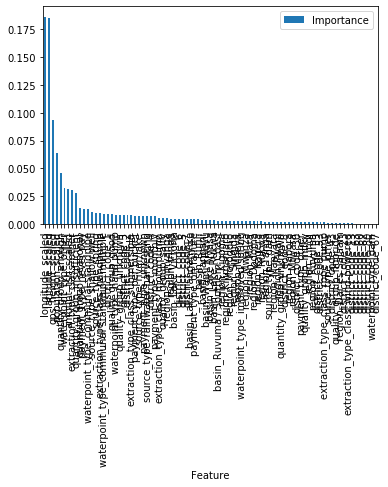

In [23]:
plt.figure(figsize=(20,40))
importances.plot.bar()

In [24]:
importances.index

Index(['longitude_scaled', 'latitude_scaled', 'gps_height_scaled',
       'population_scaled', 'quantity_group_enough', 'waterpoint_type_other',
       'amount_tsh_scaled', 'extraction_type_class_other',
       'quantity_group_insufficient', 'quantity_group_seasonal',
       'payment_type_never pay', 'waterpoint_type_communal standpipe',
       'source_type_shallow well', 'source_type_spring',
       'extraction_type_class_handpump',
       'waterpoint_type_communal standpipe multiple', 'district_code_1',
       'quality_group_good', 'waterpoint_type_hand pump',
       'quality_group_unknown', 'district_code_3', 'district_code_2',
       'extraction_type_class_submersible', 'payment_type_per bucket',
       'source_type_river/lake', 'payment_type_unknown',
       'source_type_rainwater harvesting', 'district_code_4',
       'payment_type_monthly', 'extraction_type_class_motorpump',
       'quality_group_salty', 'region_Shinyanga', 'region_Iringa',
       'basin_Lake Victoria', 'distric

In [33]:
# can features having importance > 0.007 suffice in predicting functionality of pumps?

X2 = train_features[['longitude_scaled', 'latitude_scaled', 'gps_height_scaled',
       'population_scaled', 'quantity_group_enough', 'waterpoint_type_other',
       'amount_tsh_scaled', 'extraction_type_class_other',
       'quantity_group_insufficient', 'quantity_group_seasonal',
       'payment_type_never pay', 'waterpoint_type_communal standpipe',
       'source_type_shallow well', 'source_type_spring',
       'extraction_type_class_handpump',
       'waterpoint_type_communal standpipe multiple', 'district_code_1',
       'quality_group_good', 'waterpoint_type_hand pump',
       'quality_group_unknown']].to_numpy()
y2 = train_labels

In [34]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((47520, 20), (11880, 20), (47520, 1), (11880, 1))

In [35]:
rf2 = RandomForestClassifier(n_estimators=100, oob_score=True)
rf2.fit(X2_train, y2_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [57]:
print('rf2 training score: ', rf2.score(X2_train, y2_train))

rf2 training score:  0.9926767676767677


In [36]:
y2_pred_rf2 = rf2.predict(X2_test)

In [37]:
rf2_train_score = rf2.score(X2_train, y2_train)
rf2_test_acc = accuracy_score(y2_test, y2_pred_rf2)
rf2_test_precision = precision_score(y2_test, y2_pred_rf2, average='weighted')
rf2_test_recall = recall_score(y2_test, y2_pred_rf2, average='weighted')

In [38]:
print(classification_report(y2_test, y2_pred_rf2))

                         precision    recall  f1-score   support

             functional       0.80      0.86      0.83      6457
functional needs repair       0.50      0.34      0.40       851
         non functional       0.81      0.77      0.79      4572

               accuracy                           0.79     11880
              macro avg       0.70      0.66      0.67     11880
           weighted avg       0.78      0.79      0.78     11880



In [39]:
# no great change in test accuracy
# but with above set of features, the precision & recall scores remain as before
# any more reduction affects these values

In [40]:
# repeating cross validation to ensure this result

scores2 = cross_val_score(rf2, X2_train, y2_train, cv=10, scoring='accuracy')

In [51]:
# CV scores: identical to earlier test accuracy scores ?????

print('Scores:', scores2)
print('Mean:', scores2.mean())
print('STD:', scores2.std())

Scores: [0.78072391 0.78219697 0.7834596  0.7885101  0.78619529 0.78661616
 0.7885101  0.79166667 0.78998316 0.78261785]
Mean: 0.7860479797979798
STD: 0.003480884002844506


In [42]:
# Hyperparameter Optimization

In [47]:
param_grid = {'criterion': ['gini', 'entropy'], 'min_samples_leaf':[1, 5, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'n_estimators': [100, 150, 200]}

In [48]:
clf = GridSearchCV(estimator=rf2, param_grid=param_grid, n_jobs=-1)

In [49]:
clf.fit(X2_train, y2_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=None,
                              

In [52]:
# best hyperparameters:

clf.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 150}

In [50]:
# Running Random Forest with the above

In [54]:
rf3 = RandomForestClassifier(criterion='entropy', min_samples_leaf=1, min_samples_split=8, 
                             n_estimators=150, oob_score=True)

In [55]:
rf3.fit(X2_train, y2_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
# training score quite bad with these hyperparameters. strange. 

print('rf3 training score: ', rf3.score(X2_train, y2_train))

rf3 training score:  0.9203703703703704


In [60]:
y3_pred_rf3 = rf3.predict(X2_test)

In [61]:
print(classification_report(y2_test, y3_pred_rf3))

                         precision    recall  f1-score   support

             functional       0.79      0.88      0.83      6457
functional needs repair       0.54      0.30      0.39       851
         non functional       0.82      0.76      0.79      4572

               accuracy                           0.79     11880
              macro avg       0.72      0.65      0.67     11880
           weighted avg       0.78      0.79      0.78     11880



In [63]:
# no improvement. what a disappointment

In [64]:
print('oob Score: ', rf3.oob_score_)

oob Score:  0.7947811447811448


In [65]:
# Confusion Matrix

In [68]:
predictions_rf3 = cross_val_predict(rf3, X2_train, y2_train, cv=3)

In [71]:
confusion_matrix(y2_train, predictions_rf3)

array([[22736,   482,  2584],
       [ 2011,   881,   574],
       [ 4356,   209, 13687]])

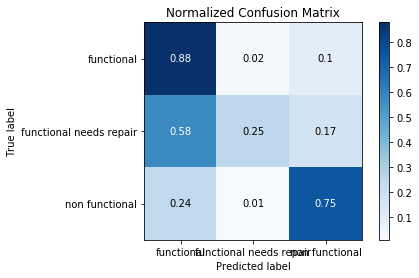

In [79]:
skplt.metrics.plot_confusion_matrix(y2_train, predictions_rf3, normalize=True)

In [80]:
# Submission

In [85]:
X_submission = test_features[['longitude_scaled', 'latitude_scaled', 'gps_height_scaled',
       'population_scaled', 'quantity_group_enough', 'waterpoint_type_other',
       'amount_tsh_scaled', 'extraction_type_class_other',
       'quantity_group_insufficient', 'quantity_group_seasonal',
       'payment_type_never pay', 'waterpoint_type_communal standpipe',
       'source_type_shallow well', 'source_type_spring',
       'extraction_type_class_handpump',
       'waterpoint_type_communal standpipe multiple', 'district_code_1',
       'quality_group_good', 'waterpoint_type_hand pump',
       'quality_group_unknown']].to_numpy()

In [86]:
y_pred_submission = rf3.predict(X_submission)

In [87]:
# no. of predictions match no. of test samples 

y_pred_submission.shape, test_features.shape

((14850,), (14850, 85))

In [88]:
# list of pump numbers in test set

test_features.index

Int64Index([50785, 51630, 17168, 45559, 49871, 52449, 24806, 28965, 36301,
            54122,
            ...
            59757, 64579, 57731, 65541, 68174, 39307, 18990, 28749, 33492,
            68707],
           dtype='int64', name='id', length=14850)

In [89]:
submission = pd.DataFrame({'id': test_features.index, 'status_group': y_pred_submission})

In [90]:
submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional


In [91]:
submission.status_group.value_counts(normalize=True)

functional                 0.632929
non functional             0.339259
functional needs repair    0.027811
Name: status_group, dtype: float64

In [ ]:
# to generate a csv

# submission.to_csv('my_submission.csv', index=False)